# Dependencies, utilities, data paths

In [30]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
import geopy.distance
%matplotlib inline
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))
def euclideanDistance(lat1, long1, lat2, long2):
    return ((long2-long1)**2 + (lat2-lat1)**2)**(0.5)
    
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"
sites_data_path = "data/sites_boston.csv"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)
sites_data = pd.read_csv(sites_data_path)

# subway data
# https://api-v3.mbta.com/docs/swagger/index.html#/Stop
# holidays data
# https://pypi.org/project/holidays/

In [31]:
features_none_null = ["host_since","host_verifications", 
                        "host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", 
                        "latitude", "longitude",
                        "room_type", "accommodates", 
                        "amenities","minimum_nights",
                        "beds", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",
                        "review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable",  "price",
                        ]
# onehot_vars = ["room_type", ]
# binary_vars = ["host_is_superhost", "instant_bookable" ]

df_none_null = listings_data.copy(deep = True)[features_none_null]
print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
print("after dropping rows with null columns: ", df_none_null.shape)


before droppign rows with null columns:  (3043, 27)
after dropping rows with null columns:  (1674, 27)


# Processing Features, numericalize, one hot, binary

In [32]:

reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null = df_none_null.drop(['host_since'], axis=1)
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')
# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)
df_none_null = df_none_null.drop(['host_response_time'], axis=1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')

room_type_dummies = pd.get_dummies(df_none_null['room_type'],prefix='room_type')
df_none_null = pd.concat([df_none_null,room_type_dummies], axis = 1)
df_none_null = df_none_null.drop(['room_type'], axis=1)

df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')

print("after processing", df_none_null.shape)
# df_none_null.dtypes



after processing (1674, 33)


# Landmark Closeness - Engineering feature

In [33]:


landmarks=sites_data["Place"]
landmarks_lats = sites_data["Latitude"]
landmarks_longs = sites_data["Longitude"]

# pending further considerations
def RMeanSquared(list_distances):
    output = []
    for i in list_distances:
        output.append(i**2)
    return np.sqrt(np.mean(output))

def SortAndGetTop(list_distances, LargeFirst=False, n=5):
    list_distances.sort(reverse=LargeFirst)
    return list_distances[0:n]

result = []

for i in range(len(df_none_null.index)):
    dist_to_each_landmark = []
    for j, landmark in enumerate(landmarks):
        # euclideanDistance(lat1, long1, lat2, long2)
        lat1,long1 = landmarks_lats[j],landmarks_longs[j]
        lat2,long2 =df_none_null.iloc[i].latitude,df_none_null.iloc[i].longitude
        # dist_to_each_landmark.append(euclideanDistance(lat1, long1, lat2, long2))
        dist_to_each_landmark.append(geopy.distance.distance((lat1, long1),(lat2, long2)).km)
    # result.append(min(dist_to_each_landmark))
    result.append(RMeanSquared(SortAndGetTop(dist_to_each_landmark)))

df_none_null["closeness_to_landmark"] = result

# for index, row in df_none_null.iterrows():
#     print(index)

In [34]:
outlier_removed = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
interested_var_df = outlier_removed[["closeness_to_landmark", "price"]]
interested_var_df.corr()

,closeness_to_landmark,price
closeness_to_landmark,1.00000,-0.28364
price,-0.28364,1.00000


# Subway Closeness - Engineering feature

In [35]:
# process subway json

import simplejson as json
subway_data_path = "data/transport/subway.json"
# attributes.name .longitude .latitude .description
# id
# within attributes.description , there is Red Blue Green Orange Line info

subway_names = []
subway_lines = []
subway_lats = []
subway_longs = []
with open(subway_data_path) as f:
    subway_data = json.load(f)['data']
    for i in subway_data:
        subway_names.append(i['attributes']['name'])
        subway_lats.append(i['attributes']['latitude'])
        subway_longs.append(i['attributes']['longitude'])
        if("Red Line" in i['attributes']['description']):
            subway_lines.append("r")
            # print(i['attributes']['description'])
        elif("Blue Line" in i['attributes']['description']):
            subway_lines.append("b")
        elif("Orange Line" in i['attributes']['description']):
            subway_lines.append("o")
        else:
            subway_lines.append(None)


result = []

for i in range(len(df_none_null.index)):
    dist_to_each_subway = []
    for j, subway in enumerate(subway_names):
        # euclideanDistance(lat1, long1, lat2, long2)
        lat1,long1 = subway_lats[j],subway_longs[j]
        lat2,long2 =df_none_null.iloc[i].latitude,df_none_null.iloc[i].longitude
        dist_to_each_subway.append(geopy.distance.distance((lat1, long1),(lat2, long2)).km)
    # result.append(min(dist_to_each_subway))
    result.append(RMeanSquared(SortAndGetTop(dist_to_each_subway)))

df_none_null["closeness_to_subway"] = result

        


In [36]:
min(df_none_null["closeness_to_subway"])

0.06796332445073772

(0.0, 1000.0)

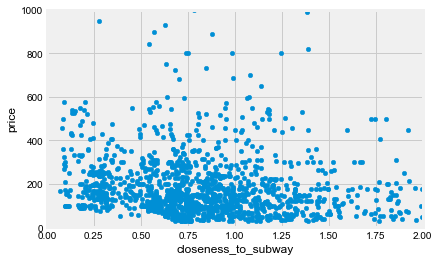

In [37]:
plot = df_none_null.plot.scatter(x="closeness_to_subway", y="price")
plot.set_xlim([0,2])
plot.set_ylim([0,1000])

In [38]:
outlier_removed = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
interested_var_df = outlier_removed[["closeness_to_subway", "price"]]
interested_var_df.corr()

,closeness_to_subway,price
closeness_to_subway,1.000000,-0.196589
price,-0.196589,1.000000


# standardization

In [39]:

# https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# standardized_df=(df-df.mean())/df.std() # standardization
# normalized_df=(df-df.min())/(df.max()-df.min()) # normalization

# drop some outliers
df_outlier_removed = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 2)]
print(df_outlier_removed.shape)
# df_outlier_removed["price"].describe()

(1656, 35)


In [40]:
features_to_standardize = ["host_number_of_years", #numerical
                        "host_verifications", #numerical
                        "host_response_rate", #numerical
                        "host_acceptance_rate",#numerical
                        "latitude", "longitude", #num
                        "accommodates", #num
                        "amenities",#num
                        "minimum_nights",#num
                        "beds", #num
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",
                        "review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "closeness_to_subway", "closeness_to_landmark",
                        "price",
                        ]
                    
features_others = ["host_response_time",#one hot
                        "host_is_superhost", #tf
                        "room_type", #one hot
                        "instant_bookable",#tf
                        ]

df_standardized_features_pre =  df_outlier_removed[features_to_standardize]
df_standardized_features = (df_standardized_features_pre - df_standardized_features_pre.mean())/df_standardized_features_pre.std()
df_combined = df_outlier_removed.copy(deep=True)
df_combined[features_to_standardize]=df_standardized_features
# df_combined.iloc[0]

In [41]:
# export dataframe,  and mean/std values for future predictions
df_combined.to_csv('data/processed/boston_processed.csv')
df_standardized_features_pre.mean().to_csv('data/processed/boston_processed_mean.csv')
df_standardized_features_pre.std().to_csv('data/processed/boston_processed_std.csv')


# modeling

## dependencies

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
# df_standardized_features.mean() .std()
# df_combined = pd.read_csv("data/processed/boston_processed.csv")
X = df_combined.drop(["price"], axis=1)
y = df_combined["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
#Cross-validation
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits()
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits()
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [45]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.41273 +/- 0.071277
Ridge: 0.41239 +/- 0.071894
Lasso: 1.02461 +/- 0.222047
ElasticNet: 0.89623 +/- 0.220826
RandomForestRegressor: 0.30511 +/- 0.070091
XGBRegressor: 0.32803 +/- 0.072254


## ridge

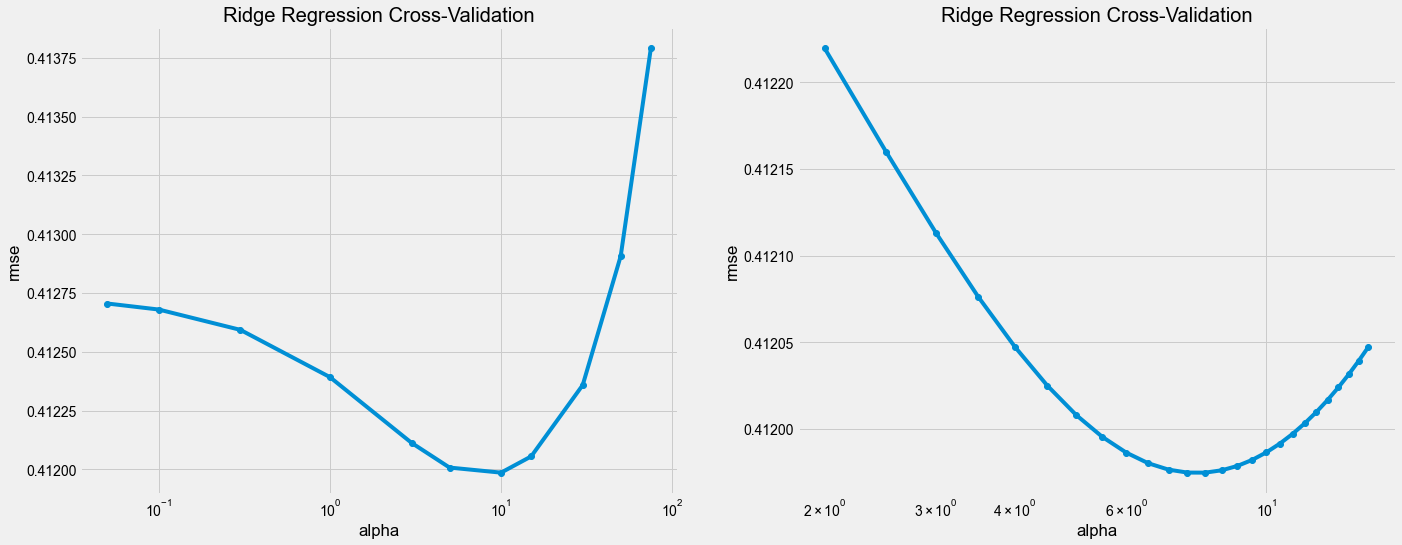

In [46]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
alphas2 = [0.5*i for i in range(4,30)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)


In [47]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas1,
        y= cv_ridge1,
        line = dict(color='royalBlue', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            )
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Coarse level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [48]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas2,
        y= cv_ridge2,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Fine level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [49]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.411975,0.073522,0.381155,0.0,0.625785,0.537533


In [52]:
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df_combined.columns, class_names=['price'], verbose=True, mode='regression')


explainer = lime.lime_tabular.LimeTabularExplainer(X_train,  
mode='regression')


TypeError: '(slice(None, None, None), 0)' is an invalid key

In [51]:
X_train

,host_verifications,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,amenities,minimum_nights,beds,...,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,closeness_to_landmark,closeness_to_subway
2471,0.237296,0.336388,0.049004,1,-1.092226,0.450950,-0.574172,0.013441,-0.480352,0.154129,...,0,0,0,1,1,0,0,0,0.760134,-0.145328
1179,-1.218119,0.336388,-0.548033,0,-0.771288,-0.671934,-0.574172,-0.418756,-0.531780,-0.547072,...,0,0,0,1,0,0,1,0,0.225265,-0.480029
942,0.237296,-0.221647,-2.476921,1,0.526541,1.309396,-0.574172,-0.959002,1.782481,-0.547072,...,0,0,1,0,0,0,1,0,-0.694294,0.053542
2192,-1.218119,0.336388,0.600115,0,-1.421105,-2.477406,-0.141190,-0.634854,-0.197498,-0.547072,...,0,0,0,1,1,0,0,0,2.193796,2.408407
487,0.722434,0.336388,-0.639884,1,-1.545654,0.548975,-0.574172,0.985884,1.782481,-0.547072,...,0,0,0,1,0,0,1,0,1.301578,-0.507097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,0.722434,0.336388,0.600115,0,-0.328690,-0.425407,0.291792,-0.418756,-0.506066,0.154129,...,0,0,0,1,1,0,0,0,-0.262886,-0.474240
2148,-1.703257,0.336388,0.508263,1,1.426538,0.994155,-0.574172,0.229539,-0.531780,-0.547072,...,0,0,0,1,1,0,0,0,-0.498389,0.064165
1374,-0.732981,0.127125,0.232708,0,0.263365,0.810481,-0.574172,-1.175100,-0.480352,-1.248273,...,0,0,0,1,0,0,1,0,-0.577421,-0.438242
2546,1.207573,0.336388,0.554189,0,0.545314,0.515757,1.157757,1.418081,-0.531780,0.154129,...,0,0,0,1,1,0,0,0,-0.776731,-0.766396


## lasso

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


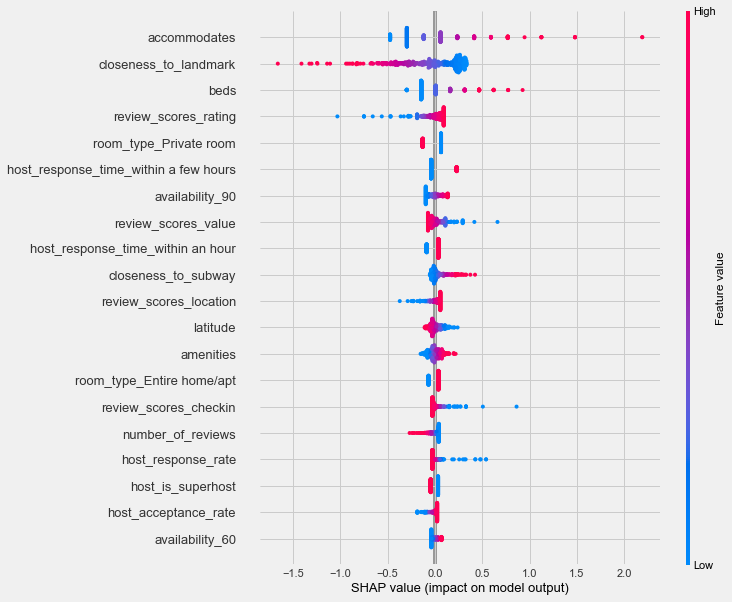

In [53]:
explainer_sh = shap.LinearExplainer(RR, X_train, feature_dependence='independent')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.412236,0.071781,0.380784,0.425773,0.626149,0.538324


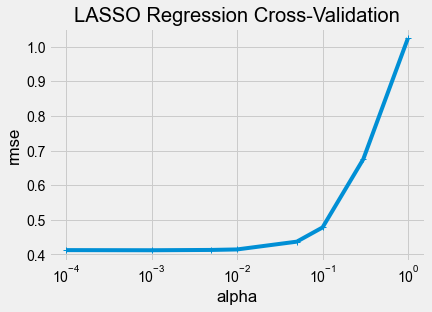

In [55]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas,
        y= cv_lasso,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Lasso penalty optimization', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()


best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

In [56]:
coef = pd.Series(lasso.coef_, index = list(X.columns))

In [57]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 32 variables and eliminated the other 2 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

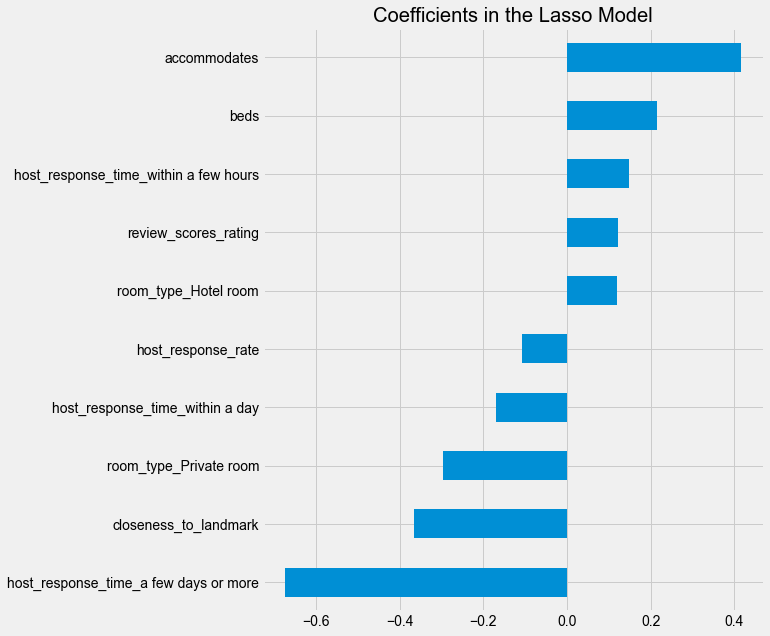

In [71]:
imp_coef = pd.concat([coef.sort_values().iloc[:5],
                     coef.sort_values().iloc[-5:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


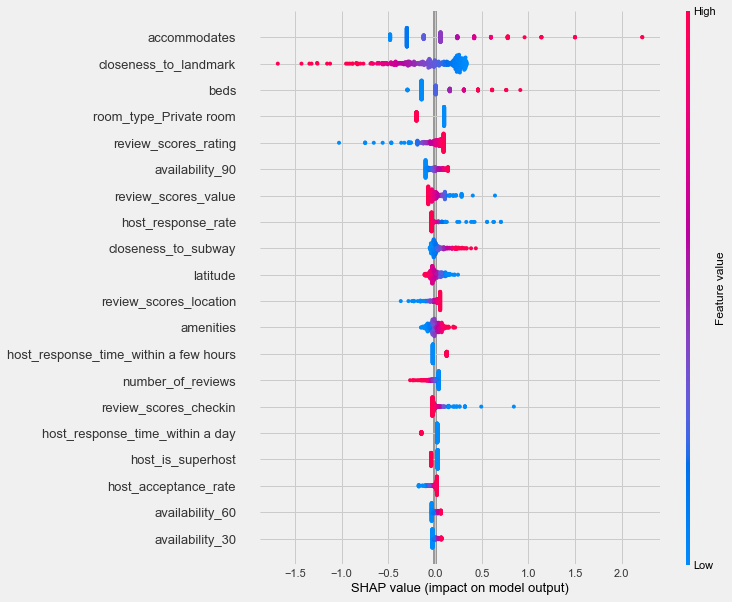

In [61]:
explainer = shap.LinearExplainer(lasso, X_train, feature_dependence='independent')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

## random forest

In [62]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [63]:
rfr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Random Forest Regressor [baseline],0.307126,0.068339,0.041562,0.302831


In [64]:
eli5.show_weights(rfr_baseline, feature_names=list(X.columns))

Weight,Feature
0.2089 ± 0.2836,beds
0.2047 ± 0.3034,accommodates
0.1229 ± 0.0759,closeness_to_landmark
0.0820 ± 0.0938,room_type_Private room
0.0340 ± 0.0585,availability_90
0.0315 ± 0.0386,availability_365
0.0249 ± 0.0234,amenities
0.0233 ± 0.0271,latitude
0.0229 ± 0.0242,host_acceptance_rate
0.0220 ± 0.0247,host_number_of_years


## Xgboost

In [66]:
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

[20:41:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:41:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:41:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindin

In [67]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping=5,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.312942,0.03433,0.000062


In [69]:
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    # continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    # makes no sense to look at max/min when we only have 3 CV folds
    #d['Max CV Error'].append(max(cv_res)
    #d['Min CV Error'].append(max(cv_res)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

# to run the search, comment out 'continue' in the for loop
# # here are the results I got
# d = {'Learning Rate':[0.01, 0.05, 0.1, 0.5],
#         'Mean CV Error': [0.184223, 0.177748, 0.175002, 0.188239],
#         'CV Error Std': [0.00626211, 0.00575213, 0.00544426, 0.00525595],
#         'Training Error': [0.179093, 0.164874, 0.154238, 0.109885]}

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

[20:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:43:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:43:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindin

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.312372,0.036117,0.019938
1,0.05,0.312942,0.034330,0.000062
2,0.10,0.310600,0.038078,0.000003
3,0.50,0.375144,0.041030,0.000001
